<a href="https://colab.research.google.com/github/MauriVass/ComplexUpper-LimbMovements/blob/master/Complex_Upper_Limb_Movements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if(os.path.isdir('ComplexUpper-LimbMovements') is False):
  ! git clone https://github.com/MauriVass/ComplexUpper-LimbMovements.git

Cloning into 'ComplexUpper-LimbMovements'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (520/520), done.
remote: Total 525 (delta 8), reused 510 (delta 3), pack-reused 0
Receiving objects: 100% (525/525), 31.41 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

!rm -rf logs

#Set a seed to get repricable results
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

simplified = False
classes = ['BostonCA', 'BostonCU', 'HarvardCA', 'HarvardCU', 'Can', 'Circle', 'Ellipse', 'Flower', 'Spiral', 'SuperMegaCloud', 'Triangle', 'Planned', 'Unplanned', 'Randomness']
classes_simple = ['Boston', 'Harvard', 'Can', 'Circle', 'Ellipse', 'Flower', 'Spiral', 'SuperMegaCloud', 'Triangle', 'Planned', 'Unplanned']

if(simplified):
  classes_lc = [x.lower() for x in classes_simple]
else: classes_lc = [x.lower() for x in classes]

#Read single csv files and save them in a dictinary <action, [array of datasets]>

In [3]:
datasets = {}
for c in classes_lc:
  datasets[c] = []

for dir in os.listdir("ComplexUpper-LimbMovements/Dataset/"):
  subdir = f"ComplexUpper-LimbMovements/Dataset/{dir}/"
  for file in os.listdir(subdir):
    #In the simplified version Randomness and Unplanned classes are merged
    classname = 'unplanned'
    if(simplified):
      for c in classes_lc:
        if(file.lower().find(c)==0):
          classname = c
    else:
      classname = [x for x in classes_lc if file.lower().find(x)==0][0]

    ds = pd.read_csv(subdir+file, sep=';', header=0)
    ds['user'] = [dir] * ds.shape[0]
    ds['action'] = [classname] * ds.shape[0]
    
    order = [4,0,1,2,3,5] # setting column's order
    ds = ds[[ds.columns[i] for i in order]]

    print(classname, subdir+file)
    datasets[classname].append(ds)

spiral ComplexUpper-LimbMovements/Dataset/S06/Spiral01.csv
flower ComplexUpper-LimbMovements/Dataset/S06/Flower03.csv
triangle ComplexUpper-LimbMovements/Dataset/S06/Triangle04.csv
bostonca ComplexUpper-LimbMovements/Dataset/S06/BostonCA03.csv
can ComplexUpper-LimbMovements/Dataset/S06/Can02.csv
spiral ComplexUpper-LimbMovements/Dataset/S06/Spiral03.csv
bostoncu ComplexUpper-LimbMovements/Dataset/S06/BostonCU04.csv
randomness ComplexUpper-LimbMovements/Dataset/S06/Randomness02.csv
randomness ComplexUpper-LimbMovements/Dataset/S06/Randomness01.csv
ellipse ComplexUpper-LimbMovements/Dataset/S06/Ellipse03.csv
flower ComplexUpper-LimbMovements/Dataset/S06/Flower04.csv
can ComplexUpper-LimbMovements/Dataset/S06/Can03.csv
harvardca ComplexUpper-LimbMovements/Dataset/S06/HarvardCA01.csv
harvardca ComplexUpper-LimbMovements/Dataset/S06/HarvardCA03.csv
harvardcu ComplexUpper-LimbMovements/Dataset/S06/HarvardCU05.csv
spiral ComplexUpper-LimbMovements/Dataset/S06/Spiral02.csv
bostonca ComplexUppe

In [ ]:
datasets['flower'][0]

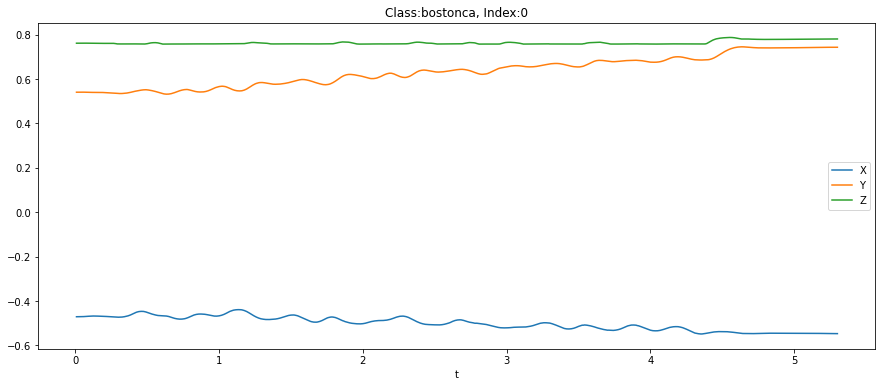

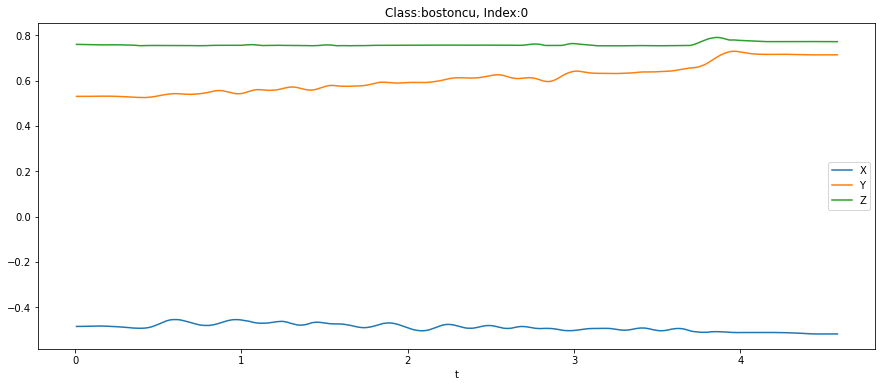

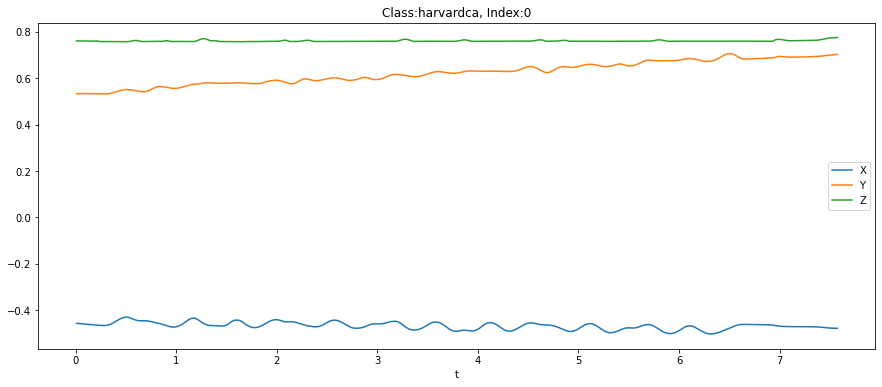

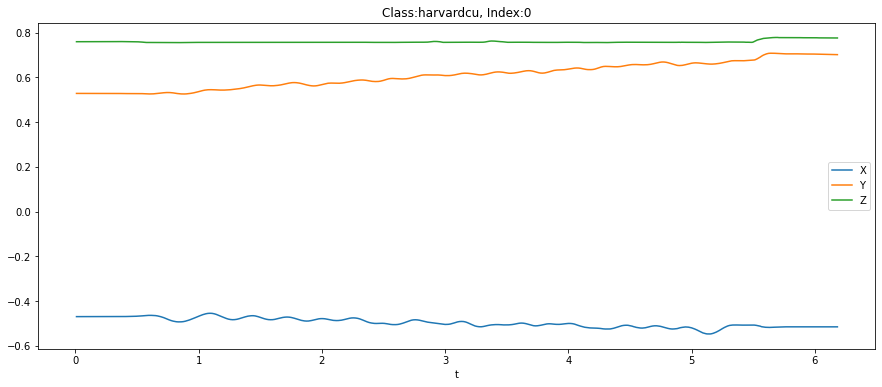

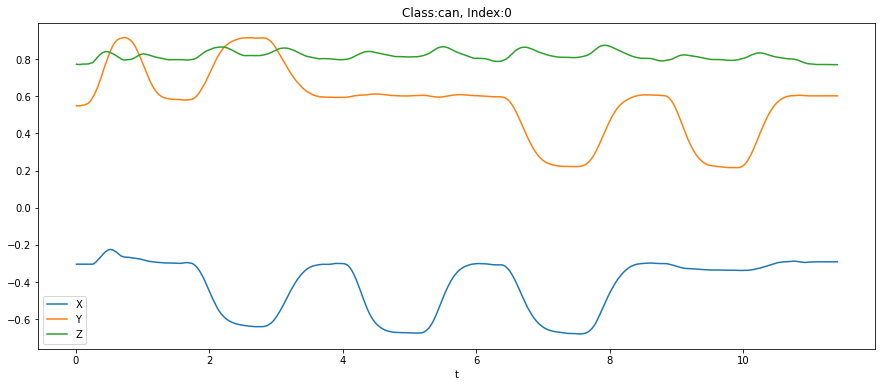

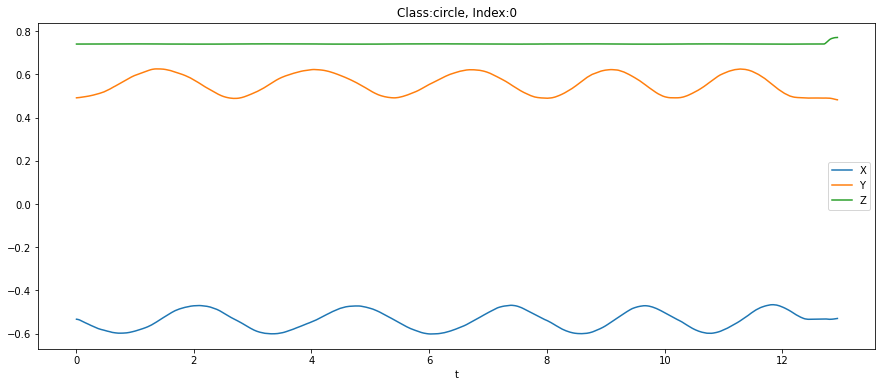

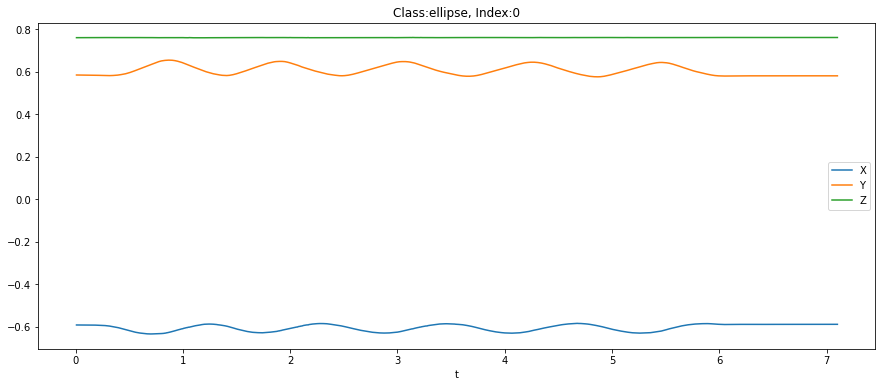

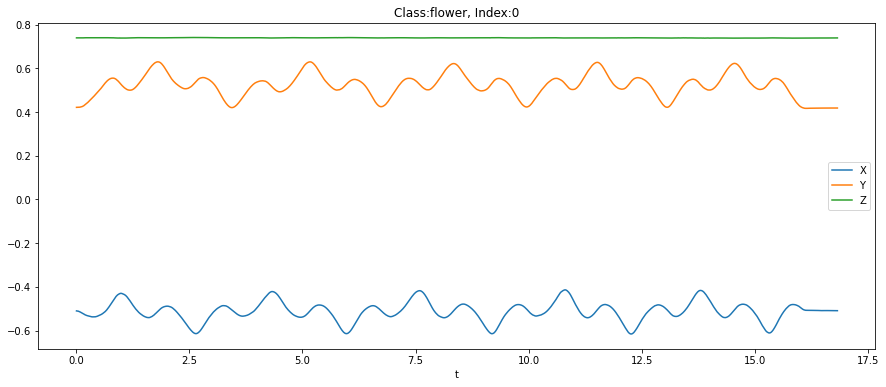

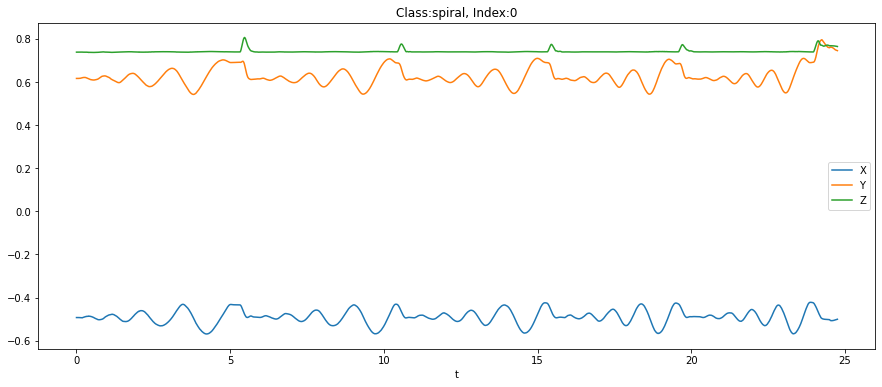

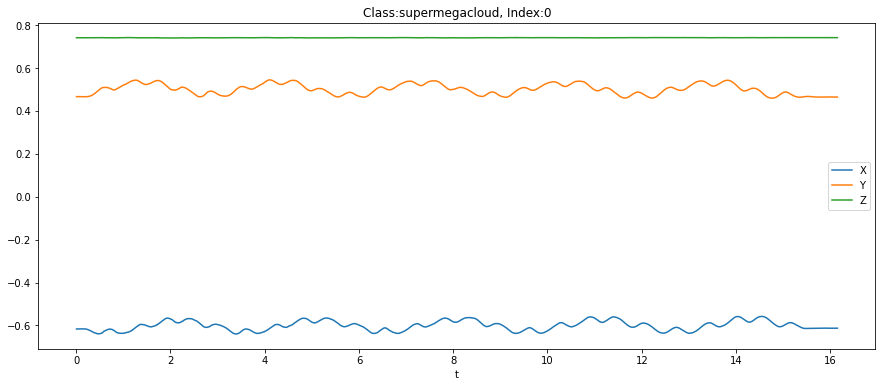

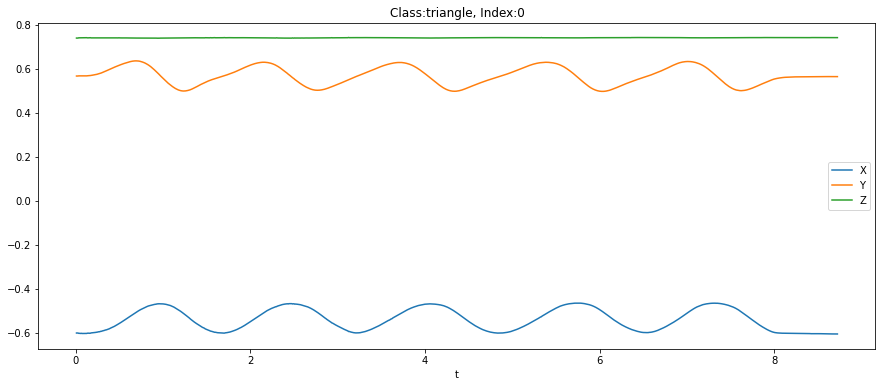

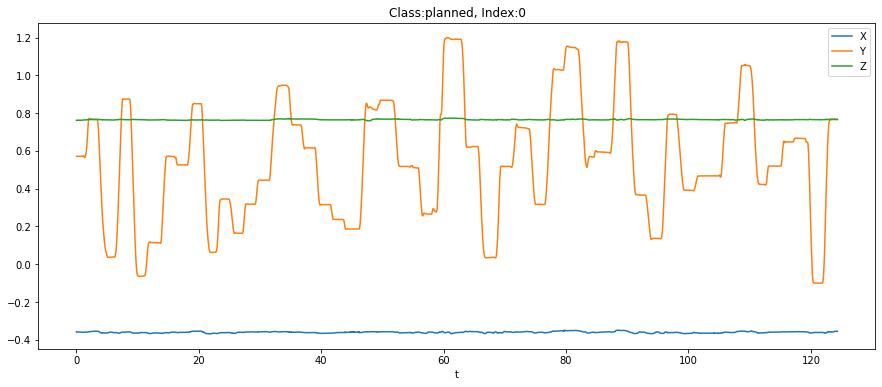

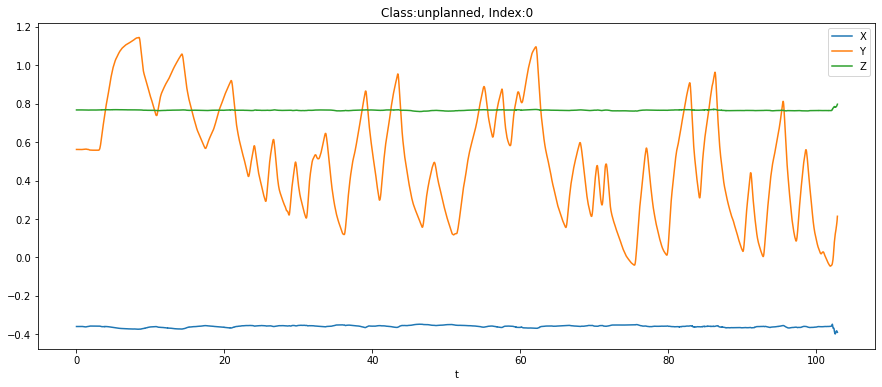

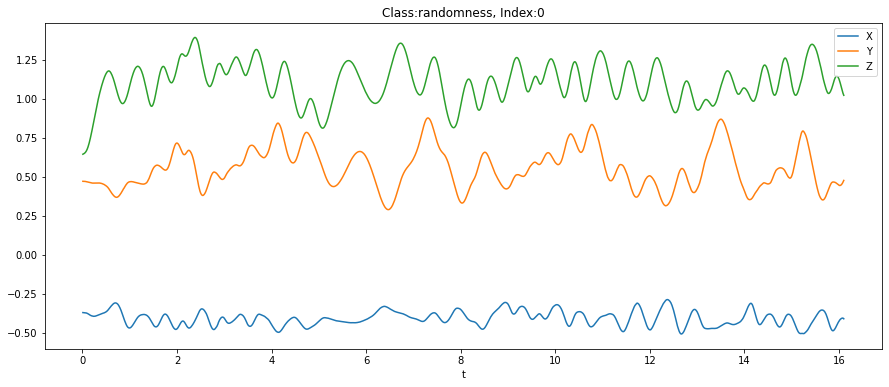

In [ ]:
def PlotDataset(classname,index, save=False):
  df = datasets[classname][index]
  title = f'Class:{classname}, Index:{index}'
  ax = df.plot(x="t", y=["X", "Y", "Z"], figsize=(15,6), title=title)
  if(save):
    ax.figure.savefig('Images/'+title)

# PlotDataset('randomess', 0)
# PlotDataset('triangle', 0)
for c in classes_lc:
  PlotDataset(c, 0, True)

#Single Dataset

##Save Dataset in one csv file
format:
user, t, x, y, z, action

In [ ]:
#DO NOT RUN THIS CELL
file = 'ComplexUpper-LimbMovements/dataset.csv'
f = open(file, 'w')
f.write('user, t, X, Y, Z, action\n')
f.close()
for k,v in datasets.items():
  for ds in v:
    ds.to_csv(file,mode='a', index=False, header=False)

##Load Dataset

In [ ]:
file = 'ComplexUpper-LimbMovements/dataset.csv'
df = pd.read_csv(file)
df.head(10)

In [ ]:
df['user'].value_counts().plot(kind='bar', figsize=(15,6))

In [ ]:
df['action'].value_counts().plot(kind='bar', figsize=(15,6))

In [ ]:
df_train = df[(df['user'] != 'S010') & (df['user'] != 'S011')]
df_test = df[(df['user'] == 'S010') | (df['user'] == 'S011')]

print(f'Whole dataset:{len(df)}, Train:{len(df_train)}({(len(df_train)/len(df)):.2f}%), {len(df_test)}({(len(df_test)/len(df)):.2f}%)' )

In [ ]:
df_train['action'].value_counts().plot(kind='bar', figsize=(15,6))
df_test['action'].value_counts().plot(kind='bar', figsize=(15,6))

##Scale DataFrames

In [ ]:
from sklearn.preprocessing import RobustScaler
scale_columns = ['X', 'Y', 'Z']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

#Gernerate Windows

In [5]:
from scipy import stats 
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
      v = X.iloc[i:(i + time_steps)].values
      labels = y.iloc[i: i + time_steps]
      Xs.append(v)
      ys.append(stats.mode(labels)[0][0])
    Xs = np.array(Xs)
    #Preprocess to extract features: mean, std, ...
    # Xs=preprocess(Xs)
    return Xs, np.array(ys).reshape(-1, 1)

In [6]:
from scipy import signal
from scipy import stats 

def preprocess(input):
  axis = 1
  mean = np.mean(input, axis=axis)
  std = np.std(input, axis=axis)
  median = np.median(input, axis=axis)
  minv = np.min(input, axis=axis)
  maxv = np.max(input, axis=axis)
  p25 = np.percentile(input, 25, axis=axis)
  p50 = np.percentile(input, 50, axis=axis)
  p75 = np.percentile(input, 75, axis=axis)
  energy = np.sum(np.square(input), axis=axis)
  # fourier_entropy = stats.entropy(input, axis=axis) #may overflow
  skewness = stats.skew(input, axis=axis)
  
  result = np.concatenate([mean,std,median,minv,maxv,p25,p50,p75,energy,skewness],axis=axis)
  return result

In [26]:
# class CalculateSTFT:
#   def __init__(self, frame_length, frame_step):
#     self.frame_length=frame_length
#     self.frame_step=frame_step

#   def get_spectrogram(self, input):
#     #Calculate the STFT of the signal given frame_length and frame_step
#     stft = tf.signal.stft(input,
#             frame_length=self.frame_length,
#             frame_step=self.frame_step,
#             fft_length=self.frame_length)
#     #Transform the complex number in real number
#     spectrogram = tf.abs(stft)
#     return spectrogram

#   def preprocess_with_stft(self, input):
#     spectrogram = self.get_spectrogram(input)
#     spectrogram = tf.expand_dims(spectrogram, -1)
#     spectrogram  = tf.image.resize(spectrogram, [32,32])
#     return spectrogram
# stft = CalculateSTFT(frame_length=640, frame_step=320)

In [ ]:
# train_mean = X_train.mean()
# train_std = X_train.std()

# X_train = (train_df - train_mean) / train_std
# X_test = (X_test - train_mean) / train_std
# X_val = (X_val - train_mean) / train_std

In [7]:
train_size = 0.85
val_size = 0.1
TIME_STEPS = 128
STEP = 16

#Total number of entries and flag(total==0)
total = 0
tf_X_train = None
tf_y_train = None
tf_X_test = None
tf_y_test = None
tf_X_val = None
tf_y_val = None
for k,v in datasets.items():
  for ds in v:
    X, y = create_dataset(ds[['X', 'Y', 'Z']], ds.action, TIME_STEPS, STEP)
    #Fixed split
    # train_x_tmp = X[:int(len(X)*train_size)]
    # train_y_tmp = y[:int(len(y)*train_size)]
    # test_x_tmp = X[int(len(X)*train_size):]
    # test_y_tmp = y[int(len(y)*train_size):]

    #Split randomly
    index_train = np.random.choice(len(X),int(len(X)*train_size), replace=False)
    index_test = np.delete(np.arange(len(X)),index_train)
    train_x_tmp = X[index_train]
    train_y_tmp = y[index_train]
    test_x_tmp = X[index_test]
    test_y_tmp = y[index_test]

    index_train = np.random.choice(len(train_x_tmp),int(len(train_x_tmp)*(1-val_size)), replace=False)
    index_val = np.delete(np.arange(len(train_x_tmp)),index_train)
    train_x_tmp = X[index_train]
    train_y_tmp = y[index_train]
    val_x_tmp = X[index_val]
    val_y_tmp = y[index_val]

    tf_train_x_tmp = tf.convert_to_tensor(train_x_tmp)
    tf_train_y_tmp = tf.convert_to_tensor(train_y_tmp)
    tf_test_x_tmp = tf.convert_to_tensor(test_x_tmp)
    tf_test_y_tmp = tf.convert_to_tensor(test_y_tmp)
    tf_val_x_tmp = tf.convert_to_tensor(val_x_tmp)
    tf_val_y_tmp = tf.convert_to_tensor(val_y_tmp)

    if(total==0):
      tf_X_train = tf_train_x_tmp
      tf_y_train = tf_train_y_tmp
      tf_X_test = tf_test_x_tmp
      tf_y_test = tf_test_y_tmp
      tf_X_val = tf_val_x_tmp
      tf_y_val = tf_val_y_tmp
    else:
      tf_X_train = tf.concat([tf_X_train,tf_train_x_tmp],0)
      tf_y_train = tf.concat([tf_y_train,tf_train_y_tmp],0)
      tf_X_test = tf.concat([tf_X_test,tf_test_x_tmp],0)
      tf_y_test = tf.concat([tf_y_test,tf_test_y_tmp],0)
      tf_X_val = tf.concat([tf_X_val,tf_val_x_tmp],0)
      tf_y_val = tf.concat([tf_y_val,tf_val_y_tmp],0)
    total+=len(X)
print(f'Train X:{tf_X_train.shape}, Train y:{tf_y_train.shape}, Test X:{tf_X_test.shape}, Test y:{tf_y_test.shape}, Test X:{tf_X_val.shape}, Test y:{tf_y_val.shape}')
print(f'train/total={(len(tf_X_train)/total):.3f}, test/total={(len(tf_X_test)/total):.3f}, val/train={(len(tf_X_val)/len(tf_X_train)):.3f}')

Train X:(63990, 128, 3), Train y:(63990, 1), Test X:(12852, 128, 3), Test y:(12852, 1), Test X:(7354, 128, 3), Test y:(7354, 1)
train/total=0.760, test/total=0.153, val/train=0.115


#One Hot Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train = tf_X_train
X_test = tf_X_test
X_val = tf_X_val

enc = enc.fit(tf_y_train)
y_train = enc.transform(tf_y_train)
y_test = enc.transform(tf_y_test)
y_val = enc.transform(tf_y_val)

#Models

##Fully Connected Network

In [164]:
modelname = 'Fully Connected Network'
model = keras.Sequential()

model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Bidirectional LSTM

In [ ]:
modelname = 'Bidirectional LSTM'
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##LSTM

In [ ]:
modelname = 'LSTM'

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Conv + LSTM

In [10]:
modelname = 'Conv + LSTM'

n_steps, n_length = 8, 16
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, n_length, tf_X_train.shape[2])))
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, n_length, tf_X_test.shape[2])))
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, n_length, tf_X_val.shape[2])))

model = keras.Sequential()
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(None,n_length,tf_X_train.shape[-1])))
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

##Conv LSTM

In [ ]:
modelname = 'Conv LSTM'

n_steps, n_length = 4, 32
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, 1, n_length, tf_X_train.shape[2])), axis=[0])
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, 1, n_length, tf_X_test.shape[2])), axis=[0])
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, 1, n_length, tf_X_val.shape[2])), axis=[0])

# define model
model = keras.Sequential()
model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, tf_X_train.shape[-1])))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

In [11]:
callbacks = []
checkpoint_path = 'KSckp/'
monitor = 'val_acc'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  save_weights_only=True,
  monitor=monitor,
  mode='max',
  save_best_only=True, verbose=0)
callbacks.append(model_checkpoint_callback)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor=monitor, min_delta=0, patience=4, mode='auto',
  baseline=None, restore_best_weights=True, verbose=1)
# callbacks.append(early_stopping)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
# callbacks.append(reduce_lr)

tensor_board = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None)
# callbacks.append(tensor_board)


#Train

In [ ]:
print(modelname, X_train.shape, X_val.shape)

# opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.9)
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val,y_val),
    shuffle=True,
    callbacks=callbacks
)

In [ ]:
print(X_train[0], y_train[0])
print(X_train[10000], y_train[10000])

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=256, max_depth=12, random_state=0, verbose=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy: {(accuracy_score(y_test, y_pred)):.3f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 256


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 256


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


building tree 3 of 256


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


building tree 4 of 256


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s


building tree 5 of 256


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


building tree 6 of 256


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.5s remaining:    0.0s


building tree 7 of 256


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.2s remaining:    0.0s


building tree 8 of 256


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.0s remaining:    0.0s


building tree 9 of 256


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.7s remaining:    0.0s


building tree 10 of 256


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s remaining:    0.0s


building tree 11 of 256


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    8.3s remaining:    0.0s


building tree 12 of 256


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    9.1s remaining:    0.0s


building tree 13 of 256


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    9.9s remaining:    0.0s


building tree 14 of 256


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   10.7s remaining:    0.0s


building tree 15 of 256


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   11.4s remaining:    0.0s


building tree 16 of 256


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   12.1s remaining:    0.0s


building tree 17 of 256


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   12.8s remaining:    0.0s


building tree 18 of 256


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   13.5s remaining:    0.0s


building tree 19 of 256


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   14.2s remaining:    0.0s


building tree 20 of 256
building tree 21 of 256
building tree 22 of 256
building tree 23 of 256
building tree 24 of 256
building tree 25 of 256
building tree 26 of 256
building tree 27 of 256
building tree 28 of 256
building tree 29 of 256
building tree 30 of 256
building tree 31 of 256
building tree 32 of 256
building tree 33 of 256
building tree 34 of 256
building tree 35 of 256
building tree 36 of 256
building tree 37 of 256
building tree 38 of 256
building tree 39 of 256
building tree 40 of 256
building tree 41 of 256
building tree 42 of 256
building tree 43 of 256
building tree 44 of 256
building tree 45 of 256
building tree 46 of 256
building tree 47 of 256
building tree 48 of 256
building tree 49 of 256
building tree 50 of 256
building tree 51 of 256
building tree 52 of 256
building tree 53 of 256
building tree 54 of 256
building tree 55 of 256
building tree 56 of 256
building tree 57 of 256
building tree 58 of 256
building tree 59 of 256
building tree 60 of 256
building tree 61

[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

Accuracy: 0.764


[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    3.2s finished


In [39]:
from sklearn.svm import SVC

model = SVC(gamma='auto', verbose=True)
model.fit(X_train, list(tf.squeeze(tf_y_train).numpy()))
y_pred = model.predict(X_test)
print(f'Accuracy: {(accuracy_score(list(tf.squeeze(tf_y_test).numpy()), y_pred)):.3f}')

[LibSVM]Accuracy: 0.720


In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

solver = ['svd',  'lsqr', 'eigen'] #default=’svd’
model = LinearDiscriminantAnalysis(solver=solver[1])
model.fit(X_train, list(tf.squeeze(tf_y_train).numpy()))
y_pred = model.predict(X_test)
print(f'Accuracy: {(accuracy_score(list(tf.squeeze(tf_y_test).numpy()), y_pred)):.3f}')

Accuracy: 0.475


In [ ]:
%tensorboard --logdir logs

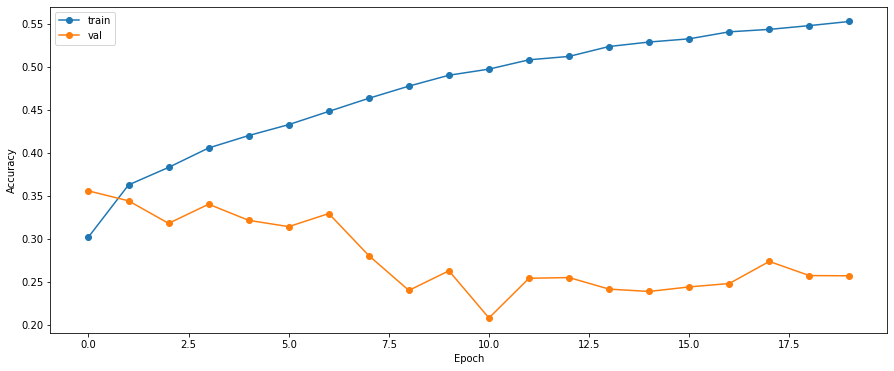

In [166]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['acc'], label='train', marker='o')
plt.plot(history.history['val_acc'], label='val', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
model.load_weights(checkpoint_path)
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
  # print(type(y_true),y_true.shape,y_true[:10] ,type(y_pred),y_pred.shape,y_pred[:10])
  y_test_non_category = [ np.argmax(t) for t in y_test ]
  y_predict_non_category = [ np.argmax(t) for t in y_pred ]

  cm = confusion_matrix(y_test_non_category, y_predict_non_category)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

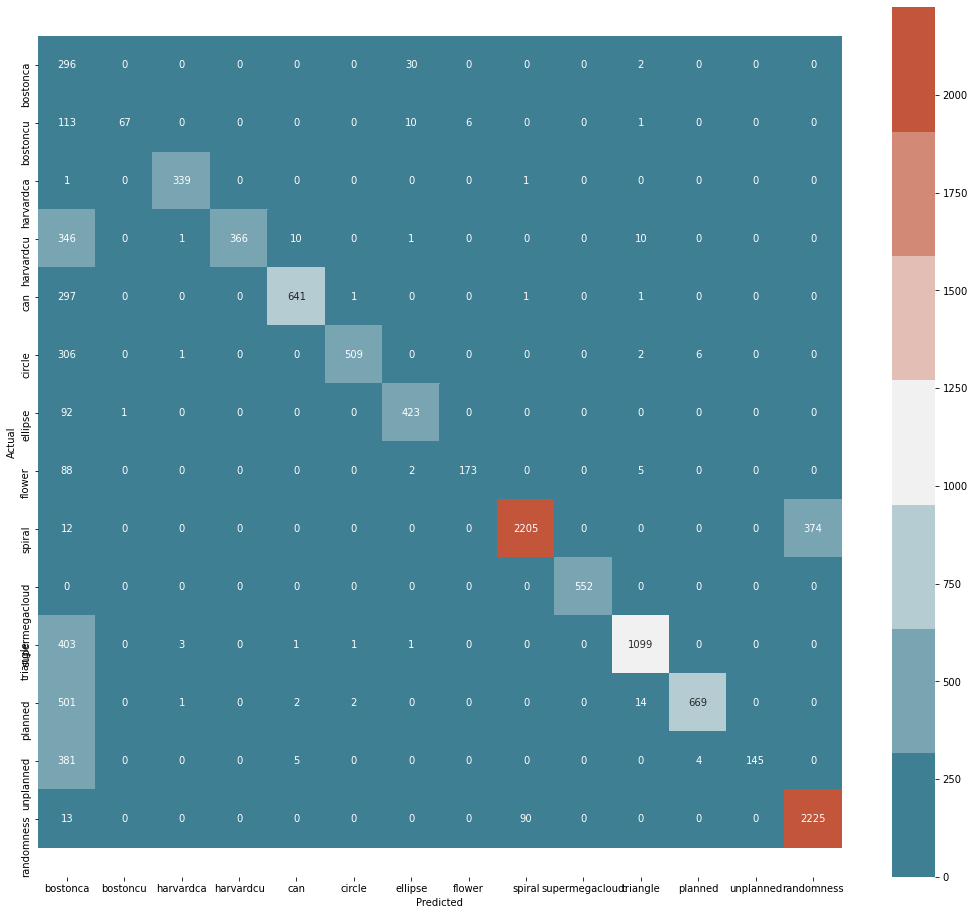

In [179]:
plot_cm(y_test,y_pred,classes_lc)